In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
npr.seed(123)
import matplotlib.pyplot as plt
%matplotlib inline
import scipy
from scipy import stats 
import seaborn as sns


1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


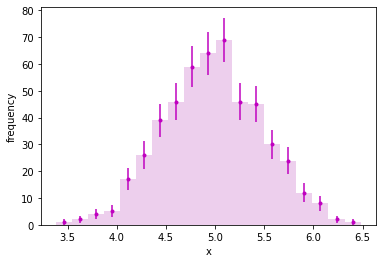

In [2]:
# exercise 1
mean = 5
std = 0.5
N = 500  
X = np.random.normal(mean,std,N)

#histogram
entries, edges, _ = plt.hist(X, bins = 'auto', color='plum',alpha=0.5)
plt.ylabel('frequency')
plt.xlabel('x')

#with points and error bars
bin_centers = 0.5 * (edges[:-1] + edges[1:])
prova = plt.errorbar(bin_centers, entries, yerr=np.sqrt(entries), fmt='m.')

Text(0.5, 1.0, 'original histogram')

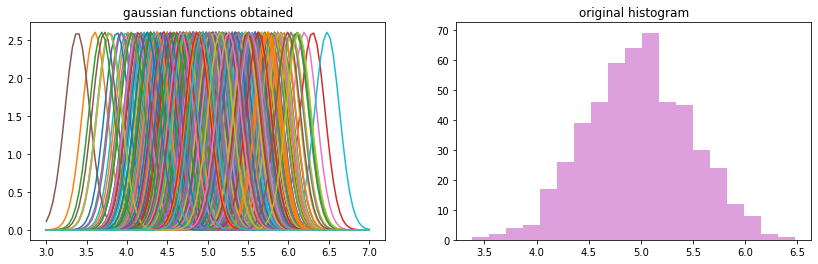

In [3]:
#for every element of x, create a gaussian with the mean corresponding the element value 
#and std as a parameter that can be tuned. 
#The std default value should be: 1.06*X.std()*X.size**(-1/5).
#you can use the scipy function stats.norm() for that.
#In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

std = 1.06*X.std()*X.size**(-1/5)  
for i in X:
    x = np.linspace(3,7,100)
    mean = i
    ax1.plot(x, stats.norm.pdf(x, mean, std))

ax1.set_title('gaussian functions obtained')
ax2.hist(X, bins = 'auto', color='plum')
ax2.set_title('original histogram')

Text(0.5, 1.0, 'KDE by hand')

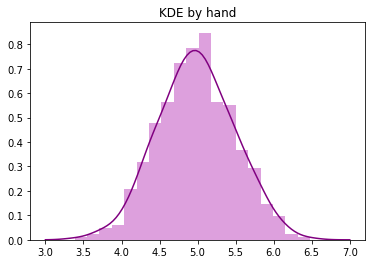

In [4]:
#Sum (with np.sum()) all the gaussian functions and normalize the result 
#such that the integral matches the integral of the original histogram. 

x = np.linspace(3,7,100)
std = 1.06*X.std()*X.size**(-1/5)  

l = []
for j in range(500):
    gaussj = stats.norm.pdf(x, X[j], std)    # gaussj is a np.array of normally distributed elements around X[j], with std
    l.append(gaussj)                         # l = list of 500 elements, each one is the gaussj array
    #plt.plot(x,gaussj)
        
sum_list = []
for i in range(100):
    elem_i = np.array([l[k][i] for k in range(len(l))]) # elem_i = array with the i-th element of every gaussj 
    sum_list.append(np.sum(elem_i))                     # sum_list = list of 100 elements, each one is the np.sum(elem_i)
    
#scipy.integrate.trapz() method to normalize
normalization = scipy.integrate.trapz(sum_list,x)
 
#plot
plt.plot(x, sum_list/normalization, c='purple')
plt.hist(X, bins = 'auto', color='plum', density=True)
plt.title('KDE by hand')

Text(0.5, 1.0, 'KDE using seaborn')

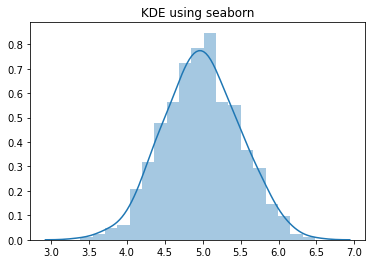

In [5]:
#comparison with the one obtained with seaborn library
sns.distplot(X)
plt.title('KDE using seaborn')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

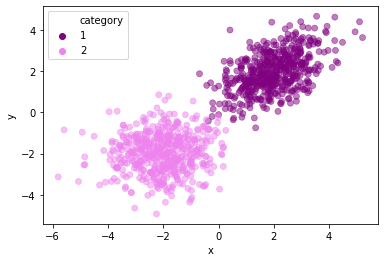

In [6]:
#exercise 2 - (generalized version with a function is below)

#generate 2D distribution
gauss1 = np.random.multivariate_normal([2, 2], [(1, 0.5), (0.5, 1)], 500)  
gauss2 = np.random.multivariate_normal([-2, -2], [(1, 0),(0, 1)], 500)

#generate 2D dataframe
cat1 = pd.DataFrame(gauss1, columns=["x", "y"])
cat1['category'] = 1        #add a column with the category
cat2 = pd.DataFrame(gauss2, columns=["x", "y"])
cat2['category'] = 2        #add a column with the category

#merge the 2 dataframes
df = pd.merge(cat1, cat2, how='outer')         

#scatter plot
sns.scatterplot(x='x', y='y', data=df, hue='category', palette=['purple', 'violet'], edgecolor='face', alpha=0.5)

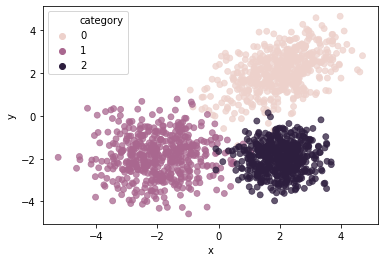

In [7]:
#generalization using a function:
N = 500
n = 3
mean = [[2, 2],[-2, -2],[2,-2]]
std = [[(1, 0.5), (0.5, 1)],[(1, 0),(0, 1)],[(0.5, 0),(0, 0.5)]]

#function to generate the 2D dataframe, with n categories
def func(mean,std,n,N):
    
    #initial dataframe with only one cat:
    df = pd.DataFrame(np.random.multivariate_normal(mean[0], std[0], N), columns=['x','y'])
    df['category'] = 0
    
    #adding to df the others cat_i
    for i in range(1, n):
        gauss_i = np.random.multivariate_normal(mean[i], std[i], N)
        cat_i = pd.DataFrame(gauss_i, columns=['x','y'])
        cat_i['category'] = i                  #add a column with the category

        #merge the dataframes      
        df = pd.merge(df, cat_i, how='outer')

    return df

dataframe = func(mean,std,n,N)
dataframe

#scatter plot
sns.scatterplot(x=dataframe['x'], y=dataframe['y'], data=dataframe, 
                hue=dataframe['category'], edgecolor='face', alpha=0.75)      

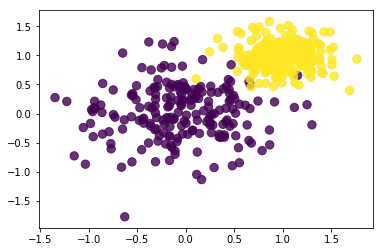

In [8]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [9]:
# exercise 3

# original dataset:
df = pd.DataFrame(np.load('residuals_261.npy',allow_pickle=True).item())
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
2,-7.200000,3.4
3,-4.150000,8.4
4,-6.590000,1.7
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [10]:
# dataset with |residuals|<2

df1 = df[abs(df['residuals'])<2]
df1

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [11]:
#linear regression of 'residuals' vs 'distances'

scipy.stats.linregress(df1['distances'],df1['residuals'])

LinregressResult(slope=0.0032597701220305835, intercept=-0.15432816763069473, rvalue=0.043403510522559086, pvalue=8.717037183576464e-06, stderr=0.0007327014008445789)

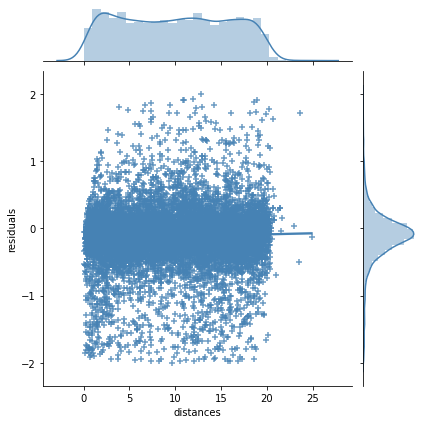

In [12]:
# Seaborn jointplot of 'residuals' vs 'distances', having seaborn performing a linear regression.
# Plot the profile plot on top of the scatter plot

sns.jointplot(x='distances', y='residuals', data=df1, marker='+', color='steelblue', kind='reg')

bin centres for distance variable 
 X = [ 0.69166667  2.075       3.45833333  4.84166667  6.225       7.60833333
  8.99166667 10.375      11.75833333 13.14166667 14.525      15.90833333
 17.29166667 18.675      20.05833333 21.44166667 22.825      24.20833333]


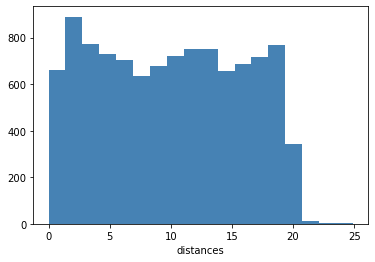

In [13]:
#Fill 3 numpy arrays: x,y,erry

# x -> serving as an array of bin centers for the "distance" variable. 
# It should range from 0 to 20 with reasonable number of steps (bins)

entriesx, edgesx, _  = plt.hist(df1['distances'], bins=18, color='steelblue')
plt.xlabel('distances')

X = 0.5 * (edgesx[:-1] + edgesx[1:])        # centers of the bins
print('bin centres for distance variable \n', 'X =', X)

In [14]:
# Y -> the mean values of the "residuals", estimated in slices (bins) of "distance"
# errY -> the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"

mean_list = []     
err_list = []
for j in range(len(edgesx)-1):     
    res_list = []
    for d,r in zip(df1['distances'],df1['residuals']):
        if (edgesx[j] < d < edgesx[j+1]):               # takes only the distances that are in the j-th bin
            res_list.append(r)                          # add to res_list the corresponding residuals
    l = np.array(res_list)      
    mean_list.append(l.mean())                          # mean of these residuals
    err_list.append(l.std())                            # std of these residuals
Y = np.array(mean_list)                                 # array with all the means
errY = np.array(err_list)                               # array with all the std
print('mean values of the "residuals", estimated in bins of "distance", \n Y = ',Y, '\n')
print('standard deviation of the of the "residuals", estimated in bins of "distance", \n errY =',errY)

mean values of the "residuals", estimated in bins of "distance", 
 Y =  [-0.19912698 -0.15759727 -0.15649748 -0.13522929 -0.11796648 -0.0817934
 -0.09874321 -0.0608212  -0.08232178 -0.12223449 -0.16387914 -0.10256699
 -0.16434505 -0.11087695 -0.02133251  0.12266667 -0.23571429  1.71      ] 

standard deviation of the of the "residuals", estimated in bins of "distance", 
 errY = [0.46462077 0.42534424 0.42123526 0.36192739 0.44888923 0.45089171
 0.4239818  0.44087393 0.47429207 0.48115501 0.46262964 0.45462792
 0.41217777 0.40574145 0.40161877 0.30381573 0.26428571 0.        ]
